# Tugas Akhir Febrian Akhmad Baehaqi

# 1. Definisi Masalah
Pada tugas akhir kali ini, saya akan melakukan sentiment analysis terhadap suatu topik. Topik yang saya pilih adalah tentang "penundaan pemilu" yang belakangan ini ramai menjadi isu yang hangat. Tujuan dari tugas akhir ini adalah untuk mengetahui sentimen masyarakat terhadap isu ini terutama warganet yang ada di twitter. Lalu, saya akan mengambil beberapa judul berita dengan menggunakan web scraping untuk mengetahui sentimen dari judul-judul berita terkait isu penundaan pemilu berdasarkan hasil dari Machine Learning model yang dibuat dari data TwitterAPI.

In [1]:
# Import packages yang dibutuhkan

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json, tweepy, requests, re, datetime, string, nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm
from pprint import pprint

indonesia_s = stopwords.words('indonesian')

In [2]:
# Mempersiapkan token untuk menggunakan TwitterAPI

with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

# 2. Data Collection
Data collection kali ini dibagi menjadi 2 bagian yaitu data collection untuk informasi tweet menggunakan TwitterAPI (Tweepy) dan data collection judul-judul berita menggunakan BeautifulSoup4.

Data-data ini diambil pada Jumat, 8 April 2022. Pengambilan data pada waktu yang berbeda dapat menyebabkan hasil data yang didapat berbeda pula.

## 2.1 TwitterAPI
Tweepy akan digunakan untuk mengumpulkan tweet-tweet mengenai penundaan pemilu selama 4 hari ke belakang (Mulai dari tanggal 3 April 2022 hingga 7 April 2022). Hasil dari penambangan TwitterAPI akan disimpan pada DataFrame df_tweets.

In [3]:
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

start_date = '2022-04-04T00:00:00Z'
end_date = '2022-04-08T00:00:00Z'

query = "penundaan pemilu -is:retweet lang:id"

response = tweepy.Paginator(api.search_recent_tweets,
                            query = query,
                            tweet_fields=['context_annotations', 'created_at'],
                            start_time = start_date,
                            end_time = end_date,
                            max_results=100
                               ).flatten()
tweets = [tweet.text.strip() for tweet in response]

In [4]:
# Menyimpan ke format .CSV
# Namun karena untuk memastikan data yang digunakan sama,
# maka line ini akan digantikan dengan membaca .csv yang sudah disimpan sebelumnya
'''
df_tweets = pd.DataFrame(tweets, columns=["tweets"])
df_tweets.to_csv("data_tweet.csv",index=False)
'''

df_tweets = pd.read_csv('data_tweet.csv', header = 0)
df_tweets

,tweets
0,"""Kalau Pak Luhut ya monggo saja, bisa evaluasi..."
1,Mahasiswa Lebak Tolak Penundaan Pemilu dan Jok...
2,@forjakeu Stop isu penundaan pemilu
3,@pelitabangsa45 Stop isu penundaan pemilu
4,"@muispebrianto Saya prihatin melihat ini, masi..."
...,...
5144,Mewaspadai Black Campaign Kelompok Oposisi Yan...
5145,Penundaan pemilu 2024 bukan hanya akan memperp...
5146,2019 Ganti Presiden disebut Makar katanya mela...
5147,Ketum PAN: Soal Isu Penundaan Pemilu Jangan Sa...


## 2.2 Web scraping
BeautifulSoup4 akan digunakan untuk melakukan web scraping. Web scraping akan dilakukan pada web Google News dan mengambil judul berita pada 15 halaman pertama tentang penundaan pemilu. Hasil judul berita dari web scraping akan disimpan pada DataFrame df_news.

In [5]:
# Mendefinisikan fungsi yang dapat melakukan web scraping pada google news dengan kata kunci "Penundaan pemilu"
def news(link, titles):
    req = Request(link, headers = {'User-Agent' : 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    with requests.Session() as c:
        soup = BeautifulSoup(webpage, 'html5lib')
        #print(soup)
        for item in soup.find_all('div', attrs={'class': 'ZINbbc luh4tb xpd O9g5cc uUPGi'}):
            # Pengambilan judul berita
            title = item.find('div', attrs={'class' : 'BNeawe vvjwJb AP7Wnd'}).get_text()
            
            titles.append(title)
    
    # Pindah ke halaman berikutnya
    next_page = soup.find('a', attrs = {'aria-label':"Halaman berikutnya"})
    next_page = next_page['href']
    link = 'https://www.google.com/' + next_page
    
    return (link, titles)

# Web yang akan digunakan
root = 'https://www.google.com/'
link = 'https://www.google.com/search?q=penundaan+pemilu&client=ms-google-coop&cx=018212539862037696382:-xa61bkyvao&tbs=qdr:w&tbm=nws&sxsrf=APq-WBt-5x9yfSf4Jc9MABPE7_FfetUPbg:1649322550899&ei=NqpOYs7BNvzD3LUPy6yCqAY&start=0&sa=N&ved=2ahUKEwjOtJCmzYH3AhX8IbcAHUuWAGU4PBDy0wN6BAgBEDg&biw=999&bih=937&dpr=1'

# Web scraping hingga 16 halaman pertama pada google news
page = 0
titles = []
while page < 16:
    link, titles = news(link, titles)
    page += 1
    

In [6]:
# Menyimpan ke format .CSV
# Namun karena untuk memastikan data yang digunakan sama jika .ipynb ini di run ulang,
# maka line ini akan digantikan dengan membaca .csv yang sudah disimpan sebelumnya
'''
df_news = pd.DataFrame(titles, columns = ['titles'])
df_news.to_csv("data_berita.csv",index=False)
'''

df_news = pd.read_csv('data_berita.csv', header = 0)
df_news

,titles
0,Projo Bersikap soal Penundaan Pemilu di Rakern...
1,PPP Nilai Jokowi Merasa Jadi Sasaran Tembak so...
2,"Diwanti-wanti Jokowi, Zulkifli Hasan Tegas Seb..."
3,Wiranto Pastikan Tidak Ada Perpanjangan Jabata...
4,Wiranto Jawab BEM Nusantara soal Penundaan Pem...
...,...
155,Proyek Pemindahan IKN Tidak Bisa Jadi Alasan P...
156,VIDEO: Ratusan Mahasiswa Berunjuk Rasa Menolak...
157,Jokowi dan Tekad APDESI untuk Penundaan Pemilu...
158,"Apdesi Diseret ke Isu Penundaan Pemilu, Jerry ..."


# 3. Data Cleaning 

Data cleaning secara umum akan melalui beberapa tahap yaitu Case Folding, Slang Word, Stopwords, dan penghapusan duplikat. 

Untuk Slang Word akan digunakan kamus Slang Word dari link berikut: https://github.com/louisowen6/NLP_bahasa_resources/blob/master/combined_slang_words.txt. 

Sedangkan untuk stopwords, akan ditambahkan beberapa stopwords baru seperti pemilu, penundaan, prokes, ibadah, aman, bentuk, vaksin, dan puasa. Pemilihan dari kata-kata khusus ini sebagai stopwords dikarenakan berbagai alasan yaitu merupakan judul dari topik (penundaan dan pemilu) dan kata-kata yang sering diulang serta di-spam karena merupakan seruan atau ajakan di dalam tweet tertentu (seperti seruan vaksin, ibadah, puasa, dll).

Penghapusan duplikat dilakukan karena banyak sekali tweet yang berulang-ulang (spam tweet) sehingga akan menyulitkan untuk melakukan analisis sentimen nantinya.

## 3.1 Data Cleaning pada DataFrame Tweet

In [7]:
# Case folding
tweets = list(map(lambda x: x.lower(),tweets))
tweets = list(map(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", x).split()),tweets))

# Slang word
slangword = eval(open("slangwords.txt").read())
pattern = re.compile(r'\b( ' + '|'.join (slangword.keys())+r')\b')

content = []
for kata in tweets:
    filteredSlang = pattern.sub(lambda x: slangword[x.group()],kata)
    content.append(filteredSlang.lower())
tweets = content

# Stopwords
stop_words = set(stopwords.words('indonesian'))
stop_words.add('pemilu')
stop_words.add('penundaan')
stop_words.add('prokes')
stop_words.add('ibadah')
stop_words.add('aman')
stop_words.add('bentuk')
stop_words.add('vaksin')
stop_words.add('puasa')
tweets_clean = []
for i in range(len(tweets)):
    word_tokens = word_tokenize(tweets[i]) 
    tweets_clean.append(' '.join([w for w in word_tokens if not w in stop_words]))
    
df_tweets['clean_tweet'] = tweets_clean

#Drop Duplicates
df_tweets.drop_duplicates(subset ="clean_tweet",
                     keep = False, inplace = True)

In [8]:
df_tweets = df_tweets.reset_index(drop=True)

In [9]:
df_tweets

,tweets,clean_tweet
0,"""Kalau Pak Luhut ya monggo saja, bisa evaluasi...",luhut iya monggo evaluasi orang beliau prime m...
1,Mahasiswa Lebak Tolak Penundaan Pemilu dan Jok...,mahasiswa lebak tolak jokowi periode april pre...
2,"@muispebrianto Saya prihatin melihat ini, masi...",prihatin menggoreng presiden periode sebenerny...
3,"Ketum parpol yg lempar isu.pemerintah Jokowi,M...",ketum partai politik lempar isu pemerintah jok...
4,@chinta_chintata Stop isu penundaan pemilu,chintata stop isu
...,...,...
2617,FAM UI :\nHentikan isu penundaan pemilu dan pe...,fam ui hentikan isu perpanjangan jabatan presi...
2618,"@VIVAcoid PDIP banyak PKI,apakah TNI juga ada....",pdip pki tni diam pki resmi peserta periode ramai
2619,Tekanan kpd jkw utk penundaan pemilu atw pun 3...,tekanan jkw atw periode tandanya kuat jk kekua...
2620,Penundaan pemilu 2024 bukan hanya akan memperp...,memperpanjang jabatan presiden wakil presiden ...


Dari hasil proses cleaning data tweet, dapat dilihat bahwa terjadi penurunan jumlah tweet yang dari yang awalnya adalah 5149 tweet, menjadi 2622 tweet. Ini artinya, setelah dilakukan pembersihan, terdapat banyak tweet-tweet yang sama atau duplikat yang mana merupakan bentuk dari spam.

# 3.2 Data Cleaning pada DataFrame Berita

In [10]:
# Case folding

titles = list(map(lambda x: x.lower(),titles))
titles = list(map(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", x).split()),titles))

# Slang word
slangword = eval(open("slangwords.txt").read())
pattern = re.compile(r'\b( ' + '|'.join (slangword.keys())+r')\b')

content = []
for kata in titles:
    filteredSlang = pattern.sub(lambda x: slangword[x.group()],kata)
    content.append(filteredSlang.lower())
titles = content

# Stopwords
titles_clean = []
for i in range(len(titles)):
    word_tokens = word_tokenize(titles[i]) 
    titles_clean.append(' '.join([w for w in word_tokens if not w in stop_words]))

In [11]:
df_news['titles_clean'] = titles_clean
df_news

,titles,titles_clean
0,Projo Bersikap soal Penundaan Pemilu di Rakern...,projo bersikap rakernas mei jokowi hadir
1,PPP Nilai Jokowi Merasa Jadi Sasaran Tembak so...,ppp nilai jokowi sasaran tembak tegur menteri ...
2,"Diwanti-wanti Jokowi, Zulkifli Hasan Tegas Seb...",diwanti wanti jokowi zulkifli hasan wacana ter...
3,Wiranto Pastikan Tidak Ada Perpanjangan Jabata...,wiranto pastikan perpanjangan jabatan presiden
4,Wiranto Jawab BEM Nusantara soal Penundaan Pem...,wiranto bem nusantara merdeka com
...,...,...
155,Proyek Pemindahan IKN Tidak Bisa Jadi Alasan P...,ribuan mahasiswa masyarakat kaltim bergerak tolak
156,VIDEO: Ratusan Mahasiswa Berunjuk Rasa Menolak...,gerakan diorkestra orang istana
157,Jokowi dan Tekad APDESI untuk Penundaan Pemilu...,sorotan berita surat palsu ksp perampok bank b...
158,"Apdesi Diseret ke Isu Penundaan Pemilu, Jerry ...",respons setneg mahasiswa ancam demo isu


# 4. Data Processing

## 4.1 Distribusi frekuensi karakter per tweet

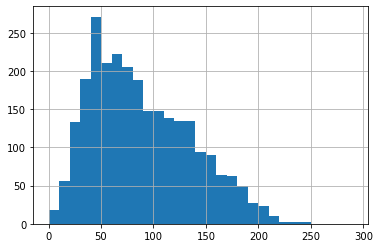

In [12]:
bin_range = np.arange(0, 300, 10)
df_tweets['clean_tweet'].str.len().hist(bins=bin_range)
plt.show()

## 4.2 Distribusi panjang kata per tweet

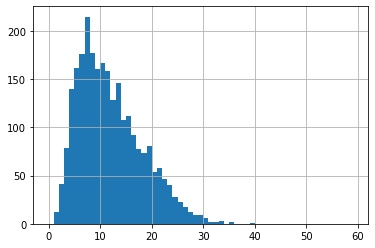

In [13]:
bin_range = np.arange(0, 60)
df_tweets['clean_tweet'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

## 4.3 Distribusi panjang rata-rata kata per tweet

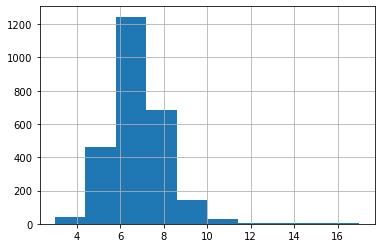

In [14]:
df_tweets['clean_tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

## 4.4 Distribusi kata

<FreqDist with 5734 samples and 30145 outcomes>
[('presiden', 1156), ('jokowi', 997), ('jabatan', 694), ('periode', 676), ('perpanjangan', 603), ('menteri', 564), ('bicara', 496), ('wacana', 361), ('isu', 319), ('rakyat', 289), ('tolak', 270), ('mahasiswa', 261), ('menolak', 258), ('konstitusi', 209), ('larang', 196), ('luhut', 183), ('fokus', 168), ('menterinya', 167), ('amp', 164), ('iya', 157)]


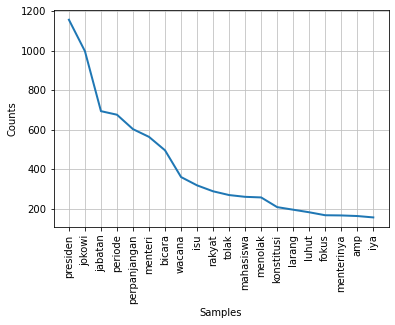

In [15]:
tweets_token = [word for tweet in df_tweets['clean_tweet'].apply(lambda x: word_tokenize(str(x))) for word in tweet]
fqdist = FreqDist(tweets_token)
print(fqdist)
most_common_word = fqdist.most_common(20)
print(most_common_word)
fqdist.plot(20,cumulative=False)
plt.show()

Dari distribusi kata yang muncul, presiden Jokowi merupakan 2 kata yang paling sering muncul. Hal ini karena penundaan pemilu otomatis akan berpengaruh langsung kepada presiden dimana akan memperpanjang masa jabatan presiden. 

## 4.5 N-gram 

Distribusi N-gram dengan 2 sampai 4 kata akan dilakukan untuk mengetahui frasa yang sering muncul pada data tweet yang dikumpulkan.

In [16]:
# N gram 2 kata
pd.Series(nltk.ngrams(tweets_token, 2)).value_counts()[:10]

(perpanjangan, jabatan)    486
(jabatan, presiden)        426
(presiden, jokowi)         211
(menteri, bicara)          172
(larang, menteri)          149
(presiden, periode)        143
(jokowi, larang)           111
(joko, widodo)              81
(big, data)                 78
(bicara, perpanjangan)      68
dtype: int64

In [17]:
# N gram 3 kata
pd.Series(nltk.ngrams(tweets_token, 3)).value_counts()[:10]

(perpanjangan, jabatan, presiden)    318
(larang, menteri, bicara)            123
(jokowi, larang, menteri)             83
(jabatan, presiden, periode)          83
(presiden, joko, widodo)              66
(bicara, perpanjangan, jabatan)       58
(wacana, perpanjangan, jabatan)       52
(presiden, larang, menteri)           50
(menolak, perpanjangan, jabatan)      47
(ahy, demokrat, terbaik)              43
dtype: int64

In [18]:
# N gram 4 kata
pd.Series(nltk.ngrams(tweets_token, 4)).value_counts()[:10]

(jokowi, larang, menteri, bicara)                 66
(presiden, larang, menteri, bicara)               47
(wacana, perpanjangan, jabatan, presiden)         44
(perpanjangan, jabatan, presiden, periode)        34
(isu, perpanjangan, jabatan, presiden)            31
(tolak, perpanjangan, jabatan, presiden)          26
(menyuarakan, perpanjangan, jabatan, presiden)    24
(bicara, perpanjangan, jabatan, presiden)         21
(menolak, perpanjangan, jabatan, presiden)        21
(presiden, joko, widodo, melarang)                21
dtype: int64

## 4.6 Sentiment Analysis 

In [19]:
# Membuka kamus kata-kata yang positif dan kata-kata yang negatif
with open("./kata_positif.txt","r") as positif_file :
  positive_words = list(set(positif_file.readlines()))
with open("./kata_negatif.txt","r") as negative_file :
  negative_words = list(set(negative_file.readlines()))

In [20]:
# Melakukan analisis sentimen terhadap suatu tweet berdasarkan jumlah kata positif dan negatif yang ada di tweet
hasil = []
tweets = df_tweets['clean_tweet']
for tweet in tweets:

    tweet_clean = tweet.strip().split()
    
    good_count = 0 #nilai positif
    bad_count = 0 #nilai negatif

    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
          good_count += count

    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
          bad_count += count
    
    hasil.append(good_count - bad_count)
    

In [21]:
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df_tweets["sentiment"] = sentiments

In [22]:
print (f'''
Mean: {np.mean(hasil)}
Median: {np.median(hasil)}
quartil awal: {np.quantile(hasil,0.25)}
quartil akhir: {np.quantile(hasil,0.75)}
Standar deviasi: {np.std(hasil)}     
''')


Mean: -0.4492753623188406
Median: 0.0
quartil awal: -1.0
quartil akhir: 0.0
Standar deviasi: 1.4473671648325435     



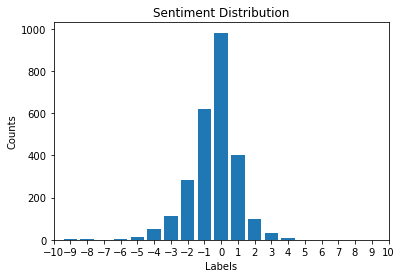

In [23]:
c = Counter(hasil)

plt.bar(c.keys(), c.values())
plt.title(f'Sentiment Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xlim([-10, 10])
plt.xticks(np.arange(-10, 11, 1.0))
plt.show()

In [24]:
df_tweets

,tweets,clean_tweet,sentiment
0,"""Kalau Pak Luhut ya monggo saja, bisa evaluasi...",luhut iya monggo evaluasi orang beliau prime m...,positif
1,Mahasiswa Lebak Tolak Penundaan Pemilu dan Jok...,mahasiswa lebak tolak jokowi periode april pre...,netral
2,"@muispebrianto Saya prihatin melihat ini, masi...",prihatin menggoreng presiden periode sebenerny...,netral
3,"Ketum parpol yg lempar isu.pemerintah Jokowi,M...",ketum partai politik lempar isu pemerintah jok...,negatif
4,@chinta_chintata Stop isu penundaan pemilu,chintata stop isu,negatif
...,...,...,...
2617,FAM UI :\nHentikan isu penundaan pemilu dan pe...,fam ui hentikan isu perpanjangan jabatan presi...,negatif
2618,"@VIVAcoid PDIP banyak PKI,apakah TNI juga ada....",pdip pki tni diam pki resmi peserta periode ramai,positif
2619,Tekanan kpd jkw utk penundaan pemilu atw pun 3...,tekanan jkw atw periode tandanya kuat jk kekua...,positif
2620,Penundaan pemilu 2024 bukan hanya akan memperp...,memperpanjang jabatan presiden wakil presiden ...,netral


Dari hasil sentimen analisis menggunakan kamus kata positif dan kata negatif, kebanyakan tweet memiliki sentimen netral namun cenderung lebih banyak yang mengarah ke sentimen negatif dibandingkan dengan sentimen positif. Dapat disimpulkan sentimen terkait isu penundaan pemilu ini adalah lebih ke negatif dan tidak baik.

## 4.7 Topic analysis 

Analisis topik akan dilakukan untuk mengetahui secara lebih spesifik topik-topik apa saja yang dibahas oleh warganet twitter terkait isu penundaan pemilu.

Dari hasil tuning dan optimasi dari parameter-parameter (alpha, beta, dan jumlah topik), didapat bahwa nilai yang optimum untuk masing-masing parameter adalah alpha = 0.31, beta = 0.91, dan jumlah topik sama dengan 5. Proses tuning ini tidak akan dimasukkan ke dalam file .ipynb ini karena akan memakan waktu yang lama.

In [25]:
data_tweet = [tweet.split() for tweet in df_tweets["clean_tweet"]]

In [26]:
dictionary = corpora.Dictionary(data_tweet)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tweet]

In [27]:
lda_model_2 = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

pprint(lda_model_2.print_topics())

[(0,
  '0.035*"jokowi" + 0.031*"bicara" + 0.028*"menteri" + 0.015*"larang" + '
  '0.012*"presiden" + 0.009*"isu" + 0.008*"fokus" + 0.008*"luhut" + '
  '0.007*"kerja" + 0.006*"booster"'),
 (1,
  '0.049*"presiden" + 0.034*"jabatan" + 0.029*"periode" + 0.029*"perpanjangan" '
  '+ 0.027*"jokowi" + 0.013*"wacana" + 0.013*"tolak" + 0.012*"menolak" + '
  '0.009*"mahasiswa" + 0.009*"menteri"'),
 (2,
  '0.014*"demokrat" + 0.012*"ahy" + 0.009*"isu" + 0.008*"terbaik" + '
  '0.005*"rakyat" + 0.004*"amp" + 0.004*"iya" + 0.004*"bohong" + '
  '0.004*"provokasi" + 0.004*"mahasiswa"'),
 (3,
  '0.013*"data" + 0.012*"luhut" + 0.011*"big" + 0.008*"harga" + '
  '0.005*"periode" + 0.005*"publik" + 0.005*"rakyat" + 0.005*"konstitusi" + '
  '0.004*"lanyalla" + 0.004*"pokok"'),
 (4,
  '0.006*"rakyat" + 0.005*"tolak" + 0.005*"wacana" + 0.005*"mpr" + 0.003*"ri" '
  '+ 0.003*"ahy" + 0.003*"orang" + 0.003*"perwakilan" + 0.003*"periode" + '
  '0.003*"dpr"')]


Beberapa topik yang dibahas dari data tweet mengenai penundaan pemilu adalah:
1. Presiden Jokowi melarang para menterinya untuk berbicara tentang wacana penundaan pemilu dan perpanjangan periode presiden.
2. Mahasiswa berdemo menolak wacana perpanjangan amasa jabatan presiden.
3. Mahasiswa mewacanakan demo untuk menolak isu penambahan periode presiden dan penundaan pemilu.
4. Menteri Luhut yang mengklaim melalui big data bahwa sekian juta rakyat Indonesia setuju dengan penundaan pemilu.
5. DPR, MPR, partai demokrat, dan rakyat setuju menolak wacana penundaan pemilu.

## 4.8 Sentiment Analysis (Machine Learning)

Dalam melakukan sentiment analisis menggunakan machine learning, model ML akan menggunakan data dari analisis sentimen twitter sebagai data training dan test, lalu data judul berita sebagai data prediksi. Klasifikasi sentimen dari data tweet akan menggunakan sentimen yang didapat dari bagian 4.6 tentang analisis sentimen.

In [28]:
# Mengubah data sentimen menjadi data numerik
# 1 untuk positif
# 0 untuk netral
# -1 untuk negatif

df_tweets.replace({"sentiment":{"negatif":int(-1), "positif":int(1), 'netral':int(0)}}, inplace=True)

In [29]:
df_tweets

,tweets,clean_tweet,sentiment
0,"""Kalau Pak Luhut ya monggo saja, bisa evaluasi...",luhut iya monggo evaluasi orang beliau prime m...,1
1,Mahasiswa Lebak Tolak Penundaan Pemilu dan Jok...,mahasiswa lebak tolak jokowi periode april pre...,0
2,"@muispebrianto Saya prihatin melihat ini, masi...",prihatin menggoreng presiden periode sebenerny...,0
3,"Ketum parpol yg lempar isu.pemerintah Jokowi,M...",ketum partai politik lempar isu pemerintah jok...,-1
4,@chinta_chintata Stop isu penundaan pemilu,chintata stop isu,-1
...,...,...,...
2617,FAM UI :\nHentikan isu penundaan pemilu dan pe...,fam ui hentikan isu perpanjangan jabatan presi...,-1
2618,"@VIVAcoid PDIP banyak PKI,apakah TNI juga ada....",pdip pki tni diam pki resmi peserta periode ramai,1
2619,Tekanan kpd jkw utk penundaan pemilu atw pun 3...,tekanan jkw atw periode tandanya kuat jk kekua...,1
2620,Penundaan pemilu 2024 bukan hanya akan memperp...,memperpanjang jabatan presiden wakil presiden ...,0


In [30]:
# Mengubah fitur teks menjadi numerik menggunakan TFIDF Vectorizer

vectorizer = TfidfVectorizer (max_features=2500)

v_data = vectorizer.fit_transform(df_tweets['clean_tweet']).toarray()
vectorizer.fit_transform(df_tweets['clean_tweet'])

X_train, X_test, y_train, y_test = train_test_split(v_data, df_tweets['sentiment'], test_size=0.2, random_state = 36)

In [31]:
# Melatih model
model_g = GaussianNB(var_smoothing=1.0)

model_g.fit(X_train, y_train)

GaussianNB(var_smoothing=1.0)

In [32]:
# Melihat performa dari model yang dibuat
y_preds = model_g.predict(X_test)
print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('Akurasi dari model adalah ',accuracy_score(y_test, y_preds))

[[ 98 100  20]
 [ 18 145  23]
 [  6  45  70]]
              precision    recall  f1-score   support

          -1       0.80      0.45      0.58       218
           0       0.50      0.78      0.61       186
           1       0.62      0.58      0.60       121

    accuracy                           0.60       525
   macro avg       0.64      0.60      0.59       525
weighted avg       0.65      0.60      0.59       525

Akurasi dari model adalah  0.5961904761904762


In [33]:
# Melakukan prediksi sentimen pada data judul berita
v_data = vectorizer.transform(df_news["titles_clean"]).toarray()
y_classification = model_g.predict(v_data)
df_news["sentiment"] = list(y_classification)
df_news

,titles,titles_clean,sentiment
0,Projo Bersikap soal Penundaan Pemilu di Rakern...,projo bersikap rakernas mei jokowi hadir,0
1,PPP Nilai Jokowi Merasa Jadi Sasaran Tembak so...,ppp nilai jokowi sasaran tembak tegur menteri ...,0
2,"Diwanti-wanti Jokowi, Zulkifli Hasan Tegas Seb...",diwanti wanti jokowi zulkifli hasan wacana ter...,0
3,Wiranto Pastikan Tidak Ada Perpanjangan Jabata...,wiranto pastikan perpanjangan jabatan presiden,0
4,Wiranto Jawab BEM Nusantara soal Penundaan Pem...,wiranto bem nusantara merdeka com,-1
...,...,...,...
155,Proyek Pemindahan IKN Tidak Bisa Jadi Alasan P...,ribuan mahasiswa masyarakat kaltim bergerak tolak,0
156,VIDEO: Ratusan Mahasiswa Berunjuk Rasa Menolak...,gerakan diorkestra orang istana,-1
157,Jokowi dan Tekad APDESI untuk Penundaan Pemilu...,sorotan berita surat palsu ksp perampok bank b...,0
158,"Apdesi Diseret ke Isu Penundaan Pemilu, Jerry ...",respons setneg mahasiswa ancam demo isu,-1


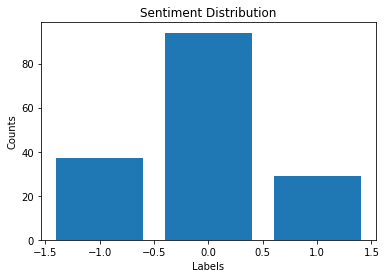

In [34]:
# Distribusi sentimen dari data judul berita yang didapat
c = Counter(df_news["sentiment"])

plt.bar(c.keys(), c.values())
plt.title(f'Sentiment Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

In [35]:
pos = df_news[df_news['sentiment']==1]['titles_clean']
positive_title = [word for title in pos.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(positive_title, 2)).value_counts()[:5]

(menteri, bicara)    4
(larang, menteri)    3
(partai, politik)    3
(jokowi, larang)     3
(jokowi, sanksi)     3
dtype: int64

In [36]:
net = df_news[df_news['sentiment']==0]['titles_clean']
neutral_title = [word for title in net.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(neutral_title, 2)).value_counts()[:5]

(jokowi, larang)           9
(menteri, bicara)          9
(larang, menteri)          8
(perpanjangan, jabatan)    6
(jabatan, presiden)        5
dtype: int64

In [37]:
neg = df_news[df_news['sentiment']==-1]['titles_clean']
negative_title = [word for title in neg.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(negative_title, 2)).value_counts()[:5]

(demo, isu)             3
(desak, luhut)          2
(dinilai, melenceng)    2
(menteri, dilarang)     2
(dilarang, bicara)      2
dtype: int64

# 5. Data Analysis

## Data tweet
Dari distribusi tweet yang didapat, sebagian besar tweet berisi 50-60 karakter, 6-10 kata, dan panjang rata-rata kata di tweet adalah 7. Sebagian besar merupakan opini dari warganet dengan beberapa merupakan judul berita dari beberapa media yang menggunakan twitter.

## Distribusi kata tweet
Dari distribusi kata pada bagian 4.4, presiden Jokowi merupakan 2 kata yang paling sering muncul. Hal ini karena penundaan pemilu otomatis akan berpengaruh langsung kepada presiden dimana akan memperpanjang masa jabatan presiden. Beberapa kata seperti menteri, penolakan, dan mahasiswa juga sering muncul.

## Distribusi N-gram
Dari distribusi N-gram 2 kata, frasa perpanjangan jabatan merupakan yang paling sering muncul karena penundaan pemilu akan memperpanjang masa jabatan dari pemegang kekuasaan. Sedangkan untuk N-gram 3 kata dan 4 kata, hal yang menarik adalah mengenai Presiden Jokowi yang melarang menteri bicara tentang perpanjangan jabatan. Dapat diasumsikan bahwa banyak menteri yang menyuarakan untuk menunda pemilu sehingga akhirnya dilarang oleh presiden.

## Sentimen analisis
Dari hasil sentimen analisis menggunakan kamus kata positif dan kata negatif, kebanyakan tweet memiliki sentimen netral namun cenderung lebih banyak yang mengarah ke sentimen negatif dibandingkan dengan sentimen positif. Dapat disimpulkan sentimen terkait isu penundaan pemilu ini adalah lebih ke negatif dan tidak baik.

Kebanyakan sentimen yang tidak baik adalah demo penolakan dari mahasiswa terhadap isu ini. Sedangkan sentimen positif dari sikap Presiden Jokowi yang melarang menterinya untuk berbicara tentang isu penundaan pemilu.

## Analisis topik
Dari analisis topik, didapat beberapa topik yang dibahas dari data tweet mengenai penundaan pemilu adalah:
1. Presiden Jokowi melarang para menterinya untuk berbicara tentang wacana penundaan pemilu dan perpanjangan periode presiden.
2. Mahasiswa berdemo menolak wacana perpanjangan amasa jabatan presiden.
3. Mahasiswa mewacanakan demo untuk menolak isu penambahan periode presiden dan penundaan pemilu.
4. Menteri Luhut yang mengklaim melalui big data bahwa sekian juta rakyat Indonesia setuju dengan penundaan pemilu.
5. DPR, MPR, partai demokrat, dan rakyat setuju menolak wacana penundaan pemilu.

## Sentimen analisis (ML)
Model yang dihasilkan memiliki skor akurasi sekitar 0.6. Hasil ini cukup baik meskipun sebenarnya dapat ditingkatkan. Untuk prediksi yang dihasilkan, kebanyakan hasil adalah netral, diikuti dengan negatif, dan positif.

Beberapa hal yang perlu diperhatikan dalam penggunaan model ini adalah:
1. Label sentimen yang digunakan di-generate secara otomatis menggunakan kamus bahasa. Hal ini tentu saja dapat menjadi perhatian karena masih memungkinkan kesalahan pelabelan yang dilakukan oleh mesin. Sebagai contoh, tweet yang sebenarnya memiliki sentimen positif namun menggunakan kata-kata yang negatif tentu saja akan dilabeli negatif. Begitu pula sebaliknya. Pelabelan secara manual oleh manusia tentu lebih diinginkan.
2. Perbedaan data train dan data test. Data train merupakan data tweet dari Twitter yang bersifat lebih bebas dan terdapat opini dari publik. Sedangkan data test merupakan data berita dari media massa yang lebih terstruktur dan terorganisir. 
3. Ketimpangan label data train dimana lebih banyak label sentimen negatif dan netral.

Dari analisis bigram, hasil prediksi netral dan positif didominasi dengan larangan Presiden Jokowi terhadap menterinya. Sedangkan prediksi negatif lebih condong kepada demo mahasiswa, menteri luhut, dan sebagian laranga dari Presiden Jokowi juga.